In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import chi2

## 1. Load Data

In [3]:
user = pd.read_csv('user_table.csv', parse_dates=['date'])
home_page = pd.read_csv('home_page_table.csv')
search_page = pd.read_csv('search_page_table.csv')
payment_page = pd.read_csv('payment_page_table.csv')
confirm = pd.read_csv('payment_confirmation_table.csv')

In [4]:
user.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [5]:
home_page.head()

,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


In [6]:
search_page.head()

,user_id,page
0,15866,search_page
1,347058,search_page
2,577020,search_page
3,780347,search_page
4,383739,search_page


In [7]:
payment_page.head()

,user_id,page
0,253019,payment_page
1,310478,payment_page
2,304081,payment_page
3,901286,payment_page
4,195052,payment_page


In [8]:
confirm.head()

,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page
2,407188,payment_confirmation_page
3,538348,payment_confirmation_page
4,841681,payment_confirmation_page


In [11]:
website_data = pd.merge(left=user, right=home_page, how='left', on='user_id')
website_data = pd.merge(left=website_data, right=search_page, how='left', on='user_id', suffixes=('_home', '_search'))
website_data = pd.merge(left=website_data, right=payment_page, how='left', on='user_id')
website_data = pd.merge(left=website_data, right=confirm, how='left', on='user_id', suffixes=('_payment', '_confirm'))

In [12]:
website_data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirm
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [14]:
website_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 0 to 90399
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       90400 non-null  int64         
 1   date          90400 non-null  datetime64[ns]
 2   device        90400 non-null  object        
 3   sex           90400 non-null  object        
 4   page_home     90400 non-null  object        
 5   page_search   45200 non-null  object        
 6   page_payment  6030 non-null   object        
 7   page_confirm  452 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 6.2+ MB


## 2. Conversion Rate Analysis

A full picture of funnel conversion rate for both desktop and mobile

In [15]:
website_data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirm
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [212]:
def conversion_rate(df):
    rates = []
    
    df1 = df[['page_home', 'page_search', 'page_payment', 'page_confirm']].count()

    for i in np.arange(0, len(df1)-1):
        rate = round(df1[i+1]/df1[i], 6)
        rates.append(rate)
        i = i+1
        
    index = ['home_to_search', 'search_to_payment', 'payment_to_confirm']
        
    return pd.DataFrame({'conversion_rate':rates}, index=index)

### 2.1 Overall Conversion Rate

In [213]:
overall_conv = conversion_rate(website_data)
overall_conv

,conversion_rate
home_to_search,0.500000
search_to_payment,0.133407
payment_to_confirm,0.074959


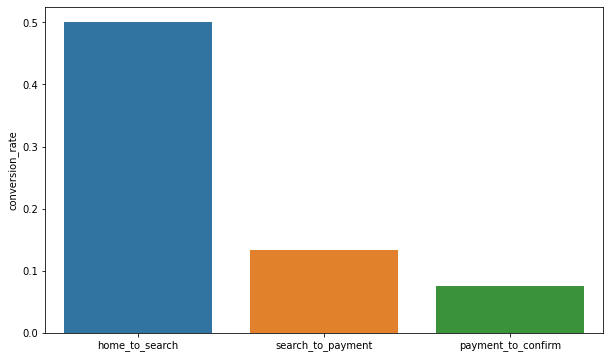

In [214]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=overall_conv.index, y='conversion_rate', data = overall_conversion, ax=ax)

### 2.2 Conversion Rate By Device

In [215]:
conv_de = website_data.groupby('device').apply(conversion_rate)
conv_de

conversion_rate
device                                     
Desktop home_to_search             0.500000
        search_to_payment          0.100000
        payment_to_confirm         0.049834
Mobile  home_to_search             0.500000
        search_to_payment          0.200000
        payment_to_confirm         0.100000

In [218]:
# Another way
conv_de.unstack(0)

conversion_rate       
device                     Desktop Mobile
home_to_search            0.500000    0.5
search_to_payment         0.100000    0.2
payment_to_confirm        0.049834    0.1

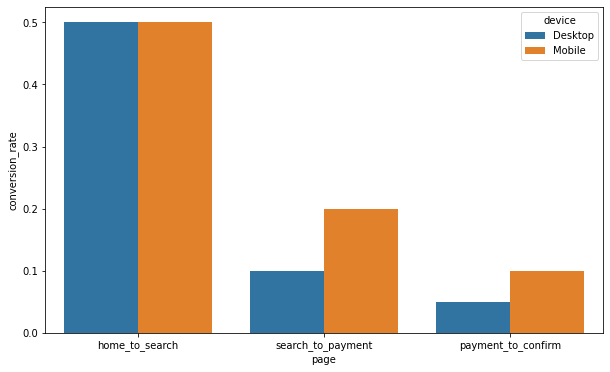

In [240]:
tem_df = conv_de.reset_index()
tem_df = tem_df.rename(columns={'level_1': 'page'})
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='page', y='conversion_rate', hue='device', data=tem_df, ax=ax)

### 2.3 Conversion Rate By Sex

In [241]:
conv_sex = website_data.groupby('sex').apply(conversion_rate)
conv_sex

conversion_rate
sex                                       
Female home_to_search             0.503073
       search_to_payment          0.136708
       payment_to_confirm         0.077742
Male   home_to_search             0.496944
       search_to_payment          0.130083
       payment_to_confirm         0.072014

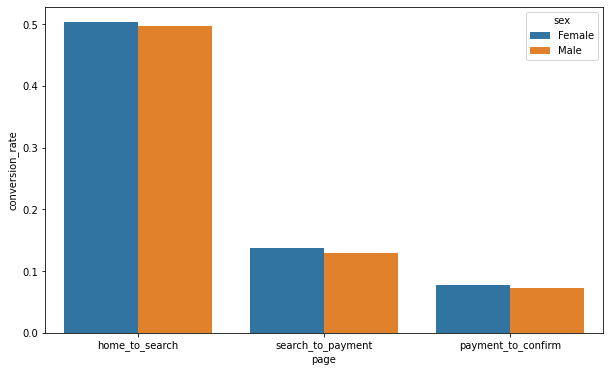

In [242]:
tem_df2 = conv_sex.reset_index()
tem_df2 = tem_df2.rename(columns={'level_1': 'page'})
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='page', y='conversion_rate', hue='sex', data=tem_df2, ax=ax)

### 2.4 Conversion Rate Over Time

In [231]:
website_data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirm
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [243]:
conv_time = website_data.groupby('date').apply(conversion_rate)

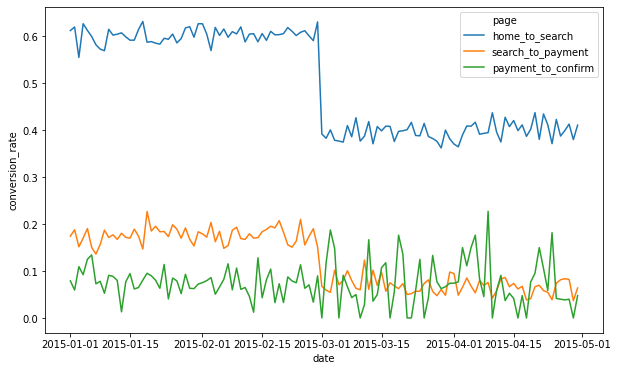

In [246]:
tem_df3 = conv_time.reset_index()
tem_df3 = tem_df3.rename(columns={'level_1': 'page'})
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='date', y='conversion_rate', hue='page', data=tem_df3, ax=ax)

From the graph:
- There is a vertical drop at 03-01, this may due to page crash or bugs. We need to take deeper look into that issue.
- home_to_search and search_to_payment conversion rate drops after 03-01
- payment_to_confirm conversion rate bounce dasticly after 03-01

CEO isn't very happy with the volumne of sales and, especially, of sales coming from new users. This may due to the bug of the conversion funnel after 03-01

### 2.5 Conversion_rate Over Time For Desktop

In [275]:
conv_time_device = website_data.groupby(['date', 'device']).apply(conversion_rate)

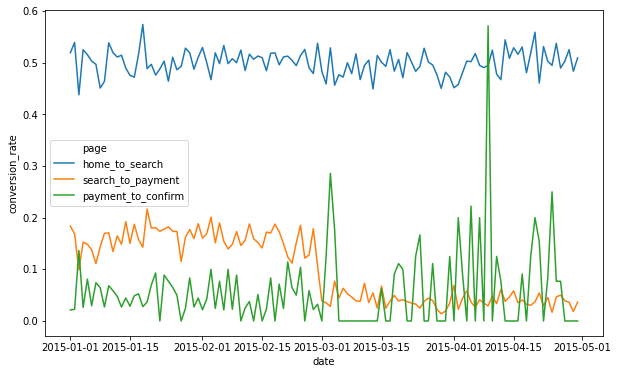

In [278]:
tem_df4 = conv_time_device.reset_index()
tem_df4 = tem_df4.rename(columns={'level_2': 'page'})
time_des = tem_df4[tem_df4['device']=='Desktop']
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='date', y='conversion_rate', hue='page', data=time_des, ax=ax)

For desktop:
- home_to_search conversion rate didn't change a lot
- search_to_payment conversion rate dropped after 03-01
- payment_to_confirm conversion rate vibrated after 03-01 and surged at 04-08 - might lead to drop in sales

### 2.6 Conversion Rate Over Time For Mobile

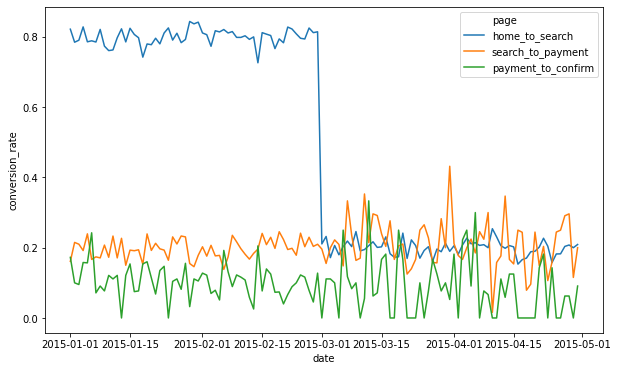

In [281]:
time_mob = tem_df4[tem_df4['device']=='Mobile']
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='date', y='conversion_rate', hue='page', data=time_mob, ax=ax)

For mobile:
- home_to_search conversion rate has a vertical drop at 03-01. This drop accounts for overall conversion rate drop from home page to search page.
    - **We need to inform the engineer team to check whether there is system issue for the website on mobile devices.**
- search_to_payment and payment_to_confirm conversion rate vibrated after 03-01, but that may due to the drop from home page conversion rate.

## 3. Statistical Analysis

#### Chi2 for feature selection

In [378]:
data = website_data.copy()
data['mobile'] = (data.device == 'Mobile').astype(int)
data['is_male'] = (data.sex == 'Male').astype(int)
data['conversion'] = (~data.page_confirm.isnull()).astype(int)
del data['device']
del data['sex']
del data['page_home']
del data['page_search']
del data['page_payment']
del data['page_confirm']

In [379]:
data['weekday'] = data.date.dt.day_name()
del data['date']

In [380]:
del data['user_id']

In [381]:
data.head()

,mobile,is_male,conversion,weekday
0,0,0,0,Saturday
1,0,1,0,Tuesday
2,0,1,0,Thursday
3,0,0,0,Wednesday
4,0,1,0,Thursday


In [382]:
data = pd.get_dummies(data, prefix='', prefix_sep='')

In [383]:
data.head()

,mobile,is_male,conversion,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,1,0,0


In [384]:
X = data.loc[:, data.columns != 'conversion']
y = data['conversion']

In [385]:
scores, pvalues = chi2(X, y)

In [388]:
chi2_df = pd.DataFrame({'chi2_value':scores, 'chi2_pvalue':pvalues}, index=X.columns).sort_values(by='chi2_value', ascending=False)
chi2_df

,chi2_value,chi2_pvalue
mobile,151.758794,7.153913e-35
Monday,2.318821,1.278169e-01
Wednesday,1.615497,2.037208e-01
Friday,1.498670,2.208761e-01
is_male,1.082703,2.980938e-01
Saturday,0.564341,4.525166e-01
Tuesday,0.481501,4.877434e-01
Sunday,0.105964,7.447867e-01
Thursday,0.022253,8.814147e-01


In [389]:
chi2_df[chi2_df['chi2_pvalue'] <= 0.05]

,chi2_value,chi2_pvalue
mobile,151.758794,7.153913e-35


- From the chi2 test, when chosen 95% significance level, only the feature 'mobile' should be included for modeling.
- For comprehensive recommendation for the product team, we might as well check all features using decision tree.

In [ ]:
del X['Tuesday']

In [416]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=10)
dt.fit(X,y)
export_graphviz(dt, out_file='tree.dot', feature_names=X.columns, class_names=['Not_convert', 'Convert'],
               proportion=True, leaves_parallel=True, filled=True)